#### Define model to be used and name of the file and video source

In [6]:
import os
import whisper
# Define what model to use possible variations are
# 'tiny.en', 'tiny', 'base.en', 'base', 'small.en', 'small', 'medium.en' 'medium', 'large-v1', 'large-v2', 'large'
# NOTE: Large models require more than 11GB VRAM
model_name = "medium.en"
audio_model = whisper.load_model(model_name)

# Define url to download video and wanted filename

name = 'SET YOUR OWN'

url = 'SET YOUR OWN'


#### Get video from internet

In [7]:
import urllib.request
import m3u8_To_MP4
# Download video
if ".m3u8" in url:
    m3u8_To_MP4.multithread_download(url)
    # Rename file
    os.rename('m3u8_To_MP4.mp4', name+".mp4")
elif ".mp4" in url:
    urllib.request.urlretrieve(url, name+".mp4")
#elif ".ts" in url:
    #subprocess.run(['ffmpeg', '-i', url, name+".mp4"])

#### Convert to mp3 and filter noise and silent parts out

In [8]:
# NOTE: install ffmpeg with choco to windows
mp4_file = name+".mp4"
mp3_file = name+".mp3"
txt_file = name+".txt"
# ~5min for 1.5h file
# Convert mp4 to mp3
os.system('ffmpeg -i {} -vn -y {}'.format(mp4_file, mp3_file))
# Remove noise
os.system("ffmpeg -i {} -af afftdn=nr=9 -y {}".format(mp3_file, "tmp_" + mp3_file))
# Remove silent spots
os.system("ffmpeg -i {} -af silenceremove=stop_periods=-1:stop_duration=3:stop_threshold=-50dB -y {}".format("tmp_" + mp3_file, mp3_file))
# Delete temporary file
os.remove("tmp_" + mp3_file)
os.remove(mp4_file)

In [9]:
LANGUAGES = {"en": "english","zh": "chinese","de": "german","es": "spanish","ru": "russian","ko": "korean","fr": "french","ja": "japanese","pt": "portuguese","tr": "turkish","pl": "polish","ca": "catalan","nl": "dutch","ar": "arabic","sv": "swedish","it": "italian","id": "indonesian","hi": "hindi","fi": "finnish","vi": "vietnamese","he": "hebrew","uk": "ukrainian","el": "greek","ms": "malay","cs": "czech","ro": "romanian","da": "danish","hu": "hungarian","ta": "tamil","no": "norwegian","th": "thai","ur": "urdu","hr": "croatian","bg": "bulgarian","lt": "lithuanian","la": "latin","mi": "maori","ml": "malayalam","cy": "welsh","sk": "slovak","te": "telugu","fa": "persian","lv": "latvian","bn": "bengali","sr": "serbian","az": "azerbaijani","sl": "slovenian","kn": "kannada","et": "estonian","mk": "macedonian","br": "breton","eu": "basque","is": "icelandic","hy": "armenian","ne": "nepali","mn": "mongolian","bs": "bosnian","kk": "kazakh","sq": "albanian","sw": "swahili","gl": "galician","mr": "marathi","pa": "punjabi","si": "sinhala","km": "khmer","sn": "shona","yo": "yoruba","so": "somali","af": "afrikaans","oc": "occitan","ka": "georgian","be": "belarusian","tg": "tajik","sd": "sindhi","gu": "gujarati","am": "amharic","yi": "yiddish","lo": "lao","uz": "uzbek","fo": "faroese","ht": "haitian creole","ps": "pashto","tk": "turkmen","nn": "nynorsk","mt": "maltese","sa": "sanskrit","lb": "luxembourgish","my": "myanmar","bo": "tibetan","tl": "tagalog","mg": "malagasy","as": "assamese","tt": "tatar","haw": "hawaiian","ln": "lingala","ha": "hausa","ba": "bashkir","jw": "javanese","su": "sundanese"}

#### Detect language if english model not used

In [10]:
if ".en" not in model_name:
    # Detect language
    audio = whisper.load_audio(mp3_file)
    audio = whisper.pad_or_trim(audio)
    mel = whisper.log_mel_spectrogram(audio).to(audio_model.device)
    _, probs = audio_model.detect_language(mel)
    detected_language = LANGUAGES[max(probs, key=probs.get)]
    print(f"Detected language: {detected_language}")

#### Generate transcribtions

In [11]:
# Transcribe audio takes about 9 min with gtx1070 to trancsribe 1.5h audio using medium.en
if ".en" not in model_name:
    result = audio_model.transcribe(mp3_file, verbose= True, language=detected_language)
else:
    result = audio_model.transcribe(mp3_file, verbose= True)

[00:00.000 --> 00:02.000]  Thank you.
[00:30.000 --> 00:32.000]  Thank you.
[01:00.000 --> 01:02.000]  Thank you.
[01:31.000 --> 01:36.000]  There were some questions in slack. I tried to answer this morning to all of them.
[01:37.000 --> 01:44.000]  The only thing I haven't figured out yet is how I can enable that you can also sign into those exercises.
[01:45.000 --> 01:51.000]  I'm working on it. This is sometimes a little bit horrible from a teacher's point of view.
[01:52.000 --> 01:54.000]  So you have no rights to do anything practically there.
[01:54.000 --> 01:59.000]  But in case it doesn't work, just go with one of the exercises.
[02:00.000 --> 02:04.000]  And just be early there in case you need the computer from there.
[02:05.000 --> 02:10.000]  But as I said, what I also heard from other courses is that you can take your own laptop there.
[02:11.000 --> 02:17.000]  And also, if you wish, you can work in the classroom with your own laptop.
[02:18.000 --> 02:20.000]  Whatev

#### Split each sentence to own row and delete .mp3-file

In [17]:
os.remove(mp3_file)

with open(txt_file, 'w') as f:
    # Write data to the file
    f.write(result["text"])
    
try:
    # Open the file for reading
    with open(txt_file, 'r') as file:
        contents = file.read()
except FileNotFoundError:
    # If the file does not exist, create a empty to be saved later
    contents = ''

# Split text where sentences end
contents = contents.replace('\n', '')
contents = contents.replace('?', '?\n')
contents = contents.replace('.', '.\n')
contents = contents.replace('!', '!\n')
# Only use this if some sentences are really long.
#contents = contents.replace(',', ',\n')

# Open the file for writing and overwrite the existing contents
with open(txt_file, 'w') as file:
    file.write(contents)

#### Embedd sentences and calulate cosine distance

2023-03-02 23:24:47,169 | INFO | Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
2023-03-02 23:24:48,028 | INFO | Use pytorch device: cuda
Batches: 100%|██████████| 22/22 [00:01<00:00, 14.68it/s]


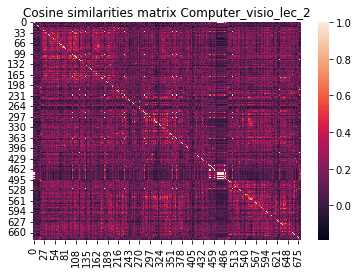

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt

sentences = []
with open(txt_file, 'r') as file:
        for line in file:
                # Remove too short lines
                if len(line)>6:
                        sentences.append(line)

# Define model to be used to be used for text embedding and create similarity matrix
text_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embeddings = text_model.encode(sentences)
similarities = cosine_similarity(embeddings)

# Plot the similarity heatmap
"""sns.heatmap(similarities).set_title('Cosine similarities matrix {}'.format(name))
plt.savefig('{}.png'.format(name), dpi=2000)"""

# Get diagonal and the one next to it for sentence similarity checking
diagonals = [similarities.diagonal(), similarities.diagonal(1)+similarities.diagonal(1)[-1]]

#### Get diagonals and detect where paragraphs should end

In [19]:
# Calculate differences
difference = [diagonals[0][i]-diagonals[1][i] for i in range(len(diagonals[0])-1)]

from scipy.ndimage import gaussian_filter1d
# Perform n-wide Gaussian smoothing
n = 1
difference_smoothed = gaussian_filter1d(difference, n)
from scipy.signal import find_peaks

# Detect peaks where sentence difference is largest
peaks, _ = find_peaks(difference_smoothed, distance=5)

"""
# Plot peaks
plt.clf()
plt.plot(difference_smoothed)
plt.plot(peaks, difference_smoothed[peaks], "x")
plt.show()"""

#### Parse final text file using detected paragraph

In [21]:
# Format text for last step and remove too short sentences.
with open(txt_file, 'r') as file:
            contents = [l.rstrip("\n").lstrip() for l in file.readlines() if len(l)>6]

# Add paragraph breaks to detected points and write to file
text = ''
for index, sentence in enumerate(contents):
        if index-1 in peaks:
                text += "\n\n"
                text += sentence
        else:
                text += " "+sentence

with open(txt_file, 'w') as file:
        file.write(text)